# Detect Volcanoes on the Venusian Surface

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

###  Read data sets

In [2]:
train_ds = pd.read_csv('data/Volcanoes_train/train_images.csv', header=None)
train_ds.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


In [3]:
test_ds = pd.read_csv('data/Volcanoes_test/test_images.csv', header=None)
test_ds.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,107,116,108,101,107,109,108,110,100,109,...,111,110,109,109,101,106,106,117,130,134
1,93,95,98,100,90,100,108,98,90,103,...,86,93,59,88,89,89,92,99,92,113
2,108,108,92,116,116,140,126,104,112,103,...,118,111,113,107,107,121,141,160,131,138
3,165,164,156,159,151,120,103,114,114,116,...,69,96,109,91,94,83,48,69,86,75
4,105,106,84,115,121,103,94,108,103,91,...,92,89,96,89,91,102,99,90,90,73


In [4]:
train_labels = pd.read_csv('data/Volcanoes_train/train_labels.csv')
train_labels

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
...,...,...,...,...
6995,0,NaN,NaN,NaN
6996,0,NaN,NaN,NaN
6997,0,NaN,NaN,NaN
6998,0,NaN,NaN,NaN


In [5]:
test_labels = pd.read_csv('data/Volcanoes_test/test_labels.csv')
test_labels

,Volcano?,Type,Radius,Number Volcanoes
0,0,NaN,NaN,NaN
1,0,NaN,NaN,NaN
2,1,1.0,17.00,1.0
3,0,NaN,NaN,NaN
4,1,3.0,15.13,1.0
...,...,...,...,...
2729,0,NaN,NaN,NaN
2730,0,NaN,NaN,NaN
2731,0,NaN,NaN,NaN
2732,0,NaN,NaN,NaN


# EDA

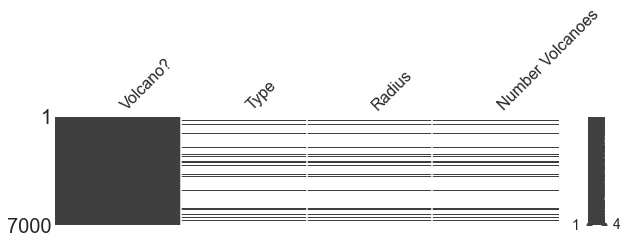

In [6]:
msno.matrix(train_labels, figsize=(10,2))
plt.show()

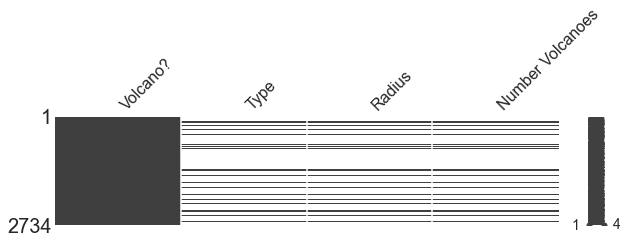

In [7]:
msno.matrix(test_labels, figsize=(10,2))
plt.show()

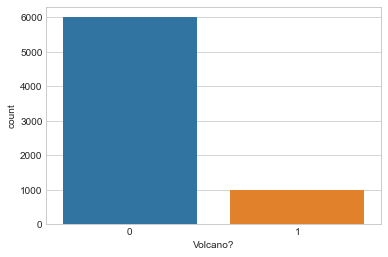

In [8]:
sns.countplot(train_labels.iloc[:,0])
plt.show()

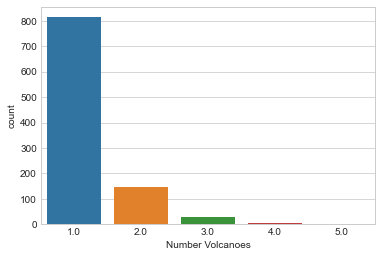

In [9]:
sns.countplot(train_labels.iloc[:,3])
plt.show()

## Images of the Venusian surface

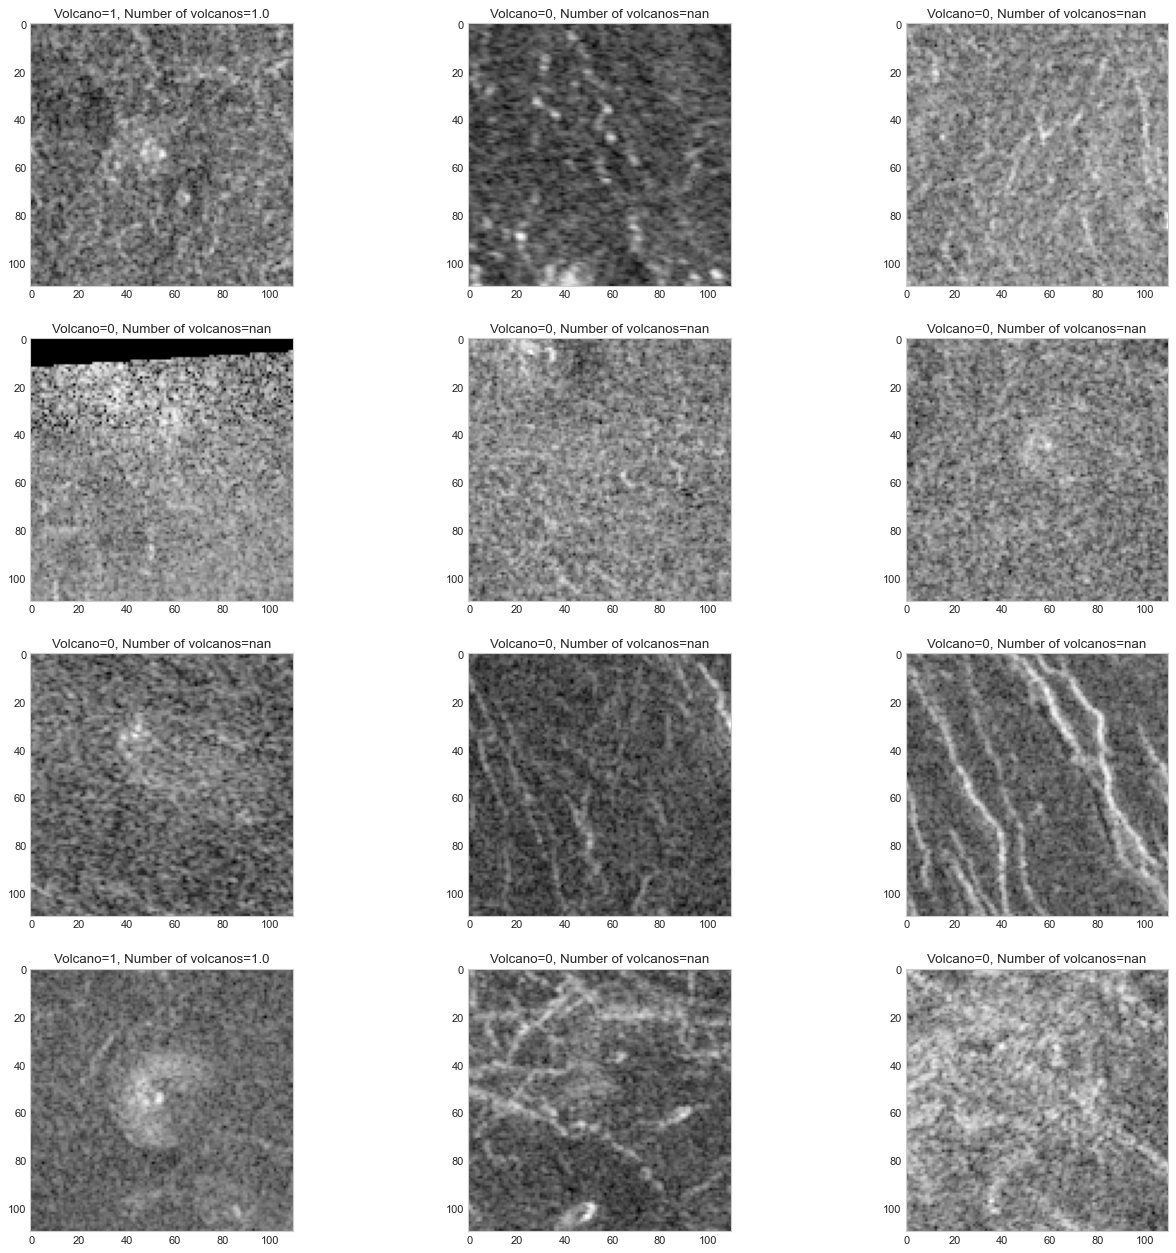

In [10]:
plt.figure(figsize=(20,20), dpi=80)
for i in range(12):
    plt.subplot(4,3,i+1)
    image = train_ds.iloc[i]
    plt.imshow(np.reshape(image.values.flatten(), (110,110,1)), cmap='gray')
    plt.grid(None)
    plt.title(f'Volcano={train_labels.iloc[i,0]}, Number of volcanos={train_labels.iloc[i,3]}')
plt.show()

# Data preprocessing

There are 7,000 images in the training data set, and 2,734 images in the test data set saved in a csv file, where each pixel of an image is in one row of the table. There are 12,100 columns, i.e., each image has 12,100 columns. $\sqrt{12,100}=110$, thus the shape of the images is 110$\times$110.

The `tensorflow` generator expects an array of rank 4, so the table is reshaped in a suitable shape.

In [11]:
train = train_ds.values.reshape(len(train_ds), 110, 110, 1)
train_labs = train_labels.iloc[:,0]

X_test = test_ds.values.reshape(len(test_ds), 110, 110, 1)
y_test = test_labels.iloc[:,0]

# Split data set in training and validation sets

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train, train_labs, test_size=0.2, stratify=train_labs, random_state=0)

## Build image generators

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow(x = X_train,
                                  y = y_train,
                                  batch_size = 32)

In [14]:
val_datagen = ImageDataGenerator(rescale = 1./255.)
val_set = val_datagen.flow(x = X_val,
                           y = y_val,
                           batch_size = 32)

# Build CNN

In [15]:
cnn = Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', strides=2, input_shape=(110,110, 1)),
    layers.MaxPooling2D(pool_size=2, padding='same', strides=2),
    
    layers.Conv2D(128, kernel_size=3, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(pool_size=2, padding='same', strides=2),
    
    layers.Conv2D(256, kernel_size=3, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(pool_size=2, padding='same', strides=2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

cnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['binary_accuracy', 'Precision', 'Recall', 'AUC'])

## Train CNN

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = cnn.fit(training_set,
        validation_data = val_set,
        epochs = 100,
        callbacks=[early_stopping])

Epoch 1/100
175/175 [==============================] - 25s 134ms/step - loss: 0.4199 - binary_accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5418 - val_loss: 0.4048 - val_binary_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6190
Epoch 2/100
175/175 [==============================] - 22s 124ms/step - loss: 0.3332 - binary_accuracy: 0.8720 - precision: 0.7986 - recall: 0.1388 - auc: 0.7882 - val_loss: 0.2929 - val_binary_accuracy: 0.8864 - val_precision: 0.5779 - val_recall: 0.7600 - val_auc: 0.9000
Epoch 3/100
175/175 [==============================] - 22s 125ms/step - loss: 0.2287 - binary_accuracy: 0.9171 - precision: 0.7927 - recall: 0.5688 - auc: 0.9042 - val_loss: 0.2414 - val_binary_accuracy: 0.9171 - val_precision: 0.8818 - val_recall: 0.4850 - val_auc: 0.9030
Epoch 4/100
175/175 [==============================] - 23s 133ms/step - loss: 0.2196 - binary_accuracy: 0.9237 - precision: 0.8166 - recall: 0.6012 - auc: 0.9121 

Epoch 31/100
175/175 [==============================] - 22s 126ms/step - loss: 0.0940 - binary_accuracy: 0.9661 - precision: 0.9111 - recall: 0.8450 - auc: 0.9843 - val_loss: 0.1398 - val_binary_accuracy: 0.9600 - val_precision: 0.9444 - val_recall: 0.7650 - val_auc: 0.9635
Epoch 32/100
175/175 [==============================] - 21s 119ms/step - loss: 0.0956 - binary_accuracy: 0.9693 - precision: 0.9187 - recall: 0.8612 - auc: 0.9844 - val_loss: 0.1280 - val_binary_accuracy: 0.9621 - val_precision: 0.9106 - val_recall: 0.8150 - val_auc: 0.9663
Epoch 33/100
175/175 [==============================] - 22s 126ms/step - loss: 0.1003 - binary_accuracy: 0.9639 - precision: 0.9041 - recall: 0.8363 - auc: 0.9815 - val_loss: 0.1430 - val_binary_accuracy: 0.9593 - val_precision: 0.9554 - val_recall: 0.7500 - val_auc: 0.9588
Epoch 34/100
175/175 [==============================] - 22s 128ms/step - loss: 0.0890 - binary_accuracy: 0.9695 - precision: 0.9188 - recall: 0.8625 - auc: 0.9856 - val_loss: 

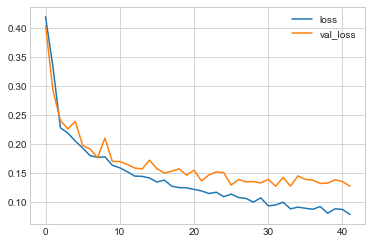

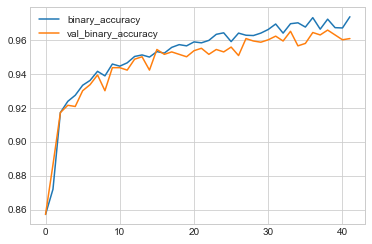

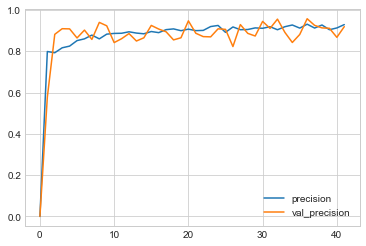

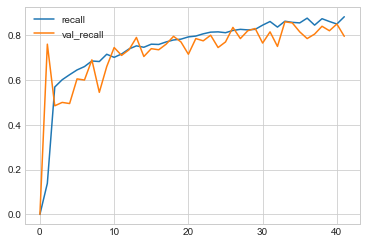

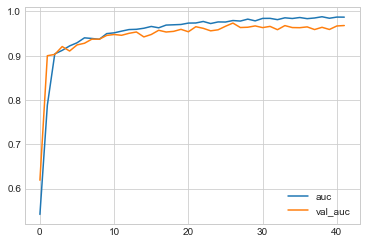

In [17]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
history_frame.loc[:, ['precision', 'val_precision']].plot()
history_frame.loc[:, ['recall', 'val_recall']].plot()
history_frame.loc[:, ['auc', 'val_auc']].plot()
plt.show()

In [18]:
history_frame.sort_values('val_auc', ascending=False)

,loss,binary_accuracy,precision,recall,auc,val_loss,val_binary_accuracy,val_precision,val_recall,val_auc
26,0.108538,0.963929,0.917598,0.82125,0.979487,0.139458,0.950714,0.822660,0.835,0.973773
41,0.079359,0.973571,0.928947,0.88250,0.987122,0.127926,0.960714,0.919075,0.795,0.968194
33,0.088955,0.969464,0.918775,0.86250,0.985619,0.128026,0.965000,0.891192,0.860,0.968031
29,0.107936,0.963929,0.912983,0.82625,0.978700,0.133644,0.958571,0.873684,0.830,0.967319
40,0.087963,0.966964,0.912752,0.85000,0.987283,0.136122,0.960000,0.867347,0.850,0.967210
25,0.114339,0.958929,0.891484,0.81125,0.976101,0.129904,0.955714,0.905882,0.770,0.966550
31,0.095587,0.969286,0.918667,0.86125,0.984398,0.127979,0.962143,0.910615,0.815,0.966256
21,0.119913,0.958214,0.899718,0.79625,0.973937,0.137155,0.955000,0.887006,0.785,0.965510
36,0.088201,0.973036,0.930943,0.87625,0.983703,0.138373,0.964286,0.957317,0.785,0.965127
28,0.100585,0.962500,0.905220,0.82375,0.982661,0.136040,0.959286,0.886486,0.820,0.964360


In [19]:
print(('Best Validation Loss: {:0.4f}' +\
      '\nBest Validation AUC: {:0.4f}')\
      .format(history_frame['val_loss'].min(), 
              history_frame['val_auc'].max()))

Best Validation Loss: 0.1279
Best Validation AUC: 0.9738


# Evaluate CNN

## Build image generator

In [20]:
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_set = test_datagen.flow(x = X_test,
                             y = y_test,
                             batch_size = 32)

## Predict

In [21]:
y_proba = cnn.predict(test_set)

In [22]:
y_pred = (y_proba >= 0.5).astype('int8')

## Metrics

In [23]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision score: {precision_score(y_test, y_pred):.6f}')
print(f'Recall score: {recall_score(y_test, y_pred):.6f}')
print(f'F1 score: {f1_score(y_test, y_pred):.6f}')
print(f'AUC score: {roc_auc_score(y_test, y_proba):.6f}')

Accuracy score: 0.744331
Precision score: 0.157623
Recall score: 0.140553
F1 score: 0.148599
AUC score: 0.507655


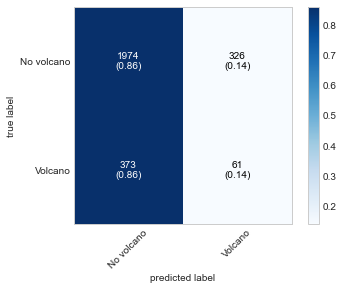

In [24]:
cm = confusion_matrix(y_test.values, y_pred.reshape(len(y_pred)))
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['No volcano', 'Volcano'])
plt.show()